In [52]:
import os
os.chdir('/Users/ngdnhtien/Codespace/PulsatingPulseShop/')

%config InlineBackend.figure_formats = ['svg']

# Contents

In this notebook, I detail how to find the phase advance of the two-subspaces in a superconducting qutrit system

In [53]:
import qiskit
from qiskit_ibm_runtime import QiskitRuntimeService
import utility as ut
import qutip as qt 
import numpy as np
import pickle 
import matplotlib.pyplot as plt
import json
import datetime

In [54]:
plt.rcParams['axes.linewidth'] = 1.0
%config InlineBackend.figure_formats = ['svg']
today = datetime.datetime.now()

print(today)

2024-10-20 10:01:47.308721


We focus on qubit 109 of the `ibmq_brisbane` processor

In [88]:
service = QiskitRuntimeService()
print(service.backends())
backend = service.backend('ibm_brisbane')

qubit = 109
clbit = 0

num_qubits = int(qubit+1)
num_clbits = 1

weight = 1

rough_01_freq = backend.defaults().qubit_freq_est[qubit]
qubit_anharmonicty = backend.properties().qubits[qubit][3].value * 1e9
rough_12_freq = rough_01_freq + qubit_anharmonicty

print('Chosen backend', backend)
print(r"f01 = "+f'{round(rough_01_freq/1e9, 4)}'+' GHz')
print(r'f12 = '+f'{round(rough_12_freq/1e9, 4)}'+' GHz')
print(r'anharmonicity = '+f'{round(qubit_anharmonicty/1e9, 4)}'+' GHz')

[<IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_kyiv')>, <IBMBackend('ibm_sherbrooke')>]
Chosen backend <IBMBackend('ibm_brisbane')>
f01 = 4.985 GHz
f12 = 4.6779 GHz
anharmonicity = -0.3071 GHz


In [5]:
calibrations = backend.defaults().instruction_schedule_map
calibrations.get('x', qubit), calibrations.get('sx', qubit)

(Schedule((0, Play(Drag(duration=120, sigma=30, beta=-1.2506749477226295, amp=0.17576112663101393, angle=0.0, name='Xp_d109'), DriveChannel(109), name='Xp_d109')), name="x"),
 Schedule((0, Play(Drag(duration=120, sigma=30, beta=-1.2506749477226295, amp=0.08782021117923207, angle=0.009279188040416471, name='X90p_d109'), DriveChannel(109), name='X90p_d109')), name="sx"))

In [6]:
sx12_params = {
    'freq': rough_12_freq,
    'dur': 40,
    'amp': 0.2361,
    'beta': -0.415,
    'angle': 0
}

sx01_params = {
    'freq': rough_01_freq,
    'dur': 120,
    'amp': 0.08782021117923207,
    'beta': -1.2506749477226295,
    'angle': 0.009780608897903031
}

# Phase advance $\beta$

In [7]:
def sched_01(phi, sign):
    '''
        Generating a rotation in 01 with an angle phi away from the x-axis
    '''
    with qiskit.pulse.build(backend=backend) as schedule:
        drive_chan = qiskit.pulse.drive_channel(qubit)
        qiskit.pulse.set_frequency(sx01_params['freq'], drive_chan)
        with qiskit.pulse.phase_offset(phi, drive_chan):
            qiskit.pulse.play(qiskit.pulse.Drag(duration=sx01_params['dur'], amp=sign*sx01_params['amp'], sigma=int(sx01_params['dur']/4), beta=sx01_params['beta']), drive_chan)
            
    return schedule

def sched_12(phi, sign):
    '''
        Generating a rotation in 12 with an angle phi away from the x-axis
    '''
    with qiskit.pulse.build(backend=backend) as schedule:
        drive_chan = qiskit.pulse.drive_channel(qubit)
        qiskit.pulse.set_frequency(sx12_params['freq'], drive_chan)
        with qiskit.pulse.phase_offset(phi, drive_chan):
            qiskit.pulse.play(qiskit.pulse.Drag(duration=sx12_params['dur'], amp=sign*sx12_params['amp'], sigma=int(sx12_params['dur']/4), beta=sx12_params['beta']), drive_chan)
            
    return schedule

#### Experiment parameters

In [82]:
rep_range = [1, 2, 3]
pa_shots = int(input('Number of shots?'))
phase_num_points = int(input('Number of phase points?'))
measurement_type = str(input('Measurement type?'))

In [83]:
print(f'Measurement of', measurement_type)
print(f'Rep range', rep_range)
print(f'Numer of shots', pa_shots)
print(f'Numer of points', phase_num_points)

Measurement of beta
Rep range [1, 2, 3]
Numer of shots 5000
Numer of points 70


In [84]:
# Gate set

sx01 = qiskit.circuit.Gate('sx01', weight, [])
sx12 = qiskit.circuit.Gate('sx12', weight, [])

sx01_plus = qiskit.circuit.Gate('sx01_plus', weight, [])
sx01_minus = qiskit.circuit.Gate('sx01_minus', weight, [])

sx12_plus = qiskit.circuit.Gate('sx12_plus', weight, [])
sx12_minus = qiskit.circuit.Gate('sx12_minus', weight, [])

axial_01 = qiskit.circuit.Gate('axial_01', weight, [])
axial_12 = qiskit.circuit.Gate('axial_12', weight, [])

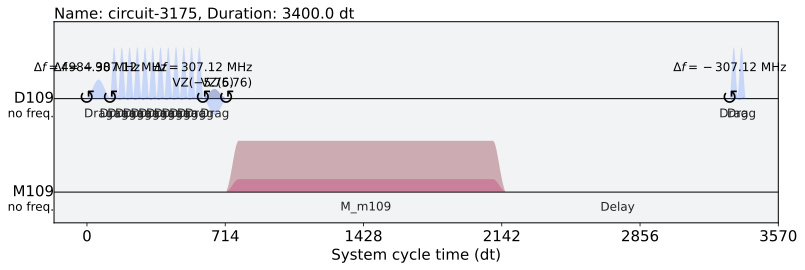

In [85]:
ramsey_experiment_circuits = []

if measurement_type == 'beta':
    for reps in rep_range:
        for phase_sweep in np.linspace(-np.pi/6, -np.pi/6+2*np.pi, phase_num_points):
            ramsey_circuit = qiskit.circuit.QuantumCircuit(num_qubits, num_clbits)
            ramsey_circuit.append(sx01, [qubit])
            for i in range(reps):
                ramsey_circuit.append(sx12_plus, [qubit])
                ramsey_circuit.append(sx12_plus, [qubit])
                ramsey_circuit.append(sx12_plus, [qubit])
                ramsey_circuit.append(sx12_plus, [qubit])
            ramsey_circuit.append(axial_01, [qubit])
            ramsey_circuit.measure(qubit, clbit)
            ramsey_circuit.append(sx12_plus, [qubit])
            ramsey_circuit.append(sx12_plus, [qubit])
            
            ramsey_circuit.add_calibration(sx01, [qubit], sched_01(phi=0, sign=+1))
            ramsey_circuit.add_calibration(sx12_plus, [qubit], sched_12(phi=0, sign=+1))
            # ramsey_circuit.add_calibration(sx12_minus, [qubit], sched_12(phi=0, sign=-1))
            ramsey_circuit.add_calibration(axial_01, [qubit], sched_01(phi=phase_sweep, sign=-1))
            ramsey_experiment_circuits.append(ramsey_circuit)
else:
    for reps in rep_range:
        for phase_sweep in np.linspace(-np.pi/6, -np.pi/6+2*np.pi, phase_num_points):
            ramsey_circuit = qiskit.circuit.QuantumCircuit(num_qubits, num_clbits)
            ramsey_circuit.append(sx01, [qubit]) 
            ramsey_circuit.append(sx01, [qubit]) # start from |1>
            ramsey_circuit.append(sx12, [qubit]) # superposition of |1> and |2>
            for i in range(reps): # pseudo
                ramsey_circuit.append(sx01_plus, [qubit]) 
                ramsey_circuit.append(sx01_plus, [qubit])
                ramsey_circuit.append(sx01_plus, [qubit]) 
                ramsey_circuit.append(sx01_plus, [qubit])  
            ramsey_circuit.append(axial_12, [qubit]) # axial 12 to record the phase
            ramsey_circuit.x(qubit) # map 0 to 1 and vice versa 
            ramsey_circuit.measure(qubit, clbit) # measure 
            ramsey_circuit.append(sx12, [qubit]) # reset
            ramsey_circuit.append(sx12, [qubit]) # reset
            
            ramsey_circuit.add_calibration(sx01, [qubit], sched_01(phi=0, sign=+1))
            ramsey_circuit.add_calibration(sx12, [qubit], sched_12(phi=0, sign=+1))
            ramsey_circuit.add_calibration(sx01_plus, [qubit], sched_01(phi=0, sign=+1))
            # ramsey_circuit.add_calibration(sx01_minus, [qubit], sched_01(phi=0, sign=-1))
            ramsey_circuit.add_calibration(axial_12, [qubit], sched_12(phi=phase_sweep, sign=-1))
            ramsey_experiment_circuits.append(ramsey_circuit) 

transpiled_circ = qiskit.transpile(ramsey_experiment_circuits[-1], backend) 
schedule = qiskit.schedule(transpiled_circ, backend)
schedule.filter(channels=[qiskit.pulse.DriveChannel(qubit), qiskit.pulse.MeasureChannel(qubit)]).draw()

In [89]:
pa_job_single = backend.run(ramsey_experiment_circuits, meas_level=1, meas_return='single', shots=pa_shots, rep_delay=0.0005)
print(pa_job_single.job_id())
pa_job_id_string = f'{pa_job_single.job_id()}'

/var/folders/z6/rm3bbyf1499dhyn1b2tcy4s80000gn/T/ipykernel_11311/3133903390.py:1: DeprecationWarning: backend.run() and related sessions methods are deprecated  as of qiskit-ibm-runtime 0.23 and will be removed no sooner than 6 months after the release date. More details can be found in the primitives migration guide https://docs.quantum.ibm.com/migration-guides/qiskit-runtime.
  pa_job_single = backend.run(ramsey_experiment_circuits, meas_level=1, meas_return='single', shots=pa_shots, rep_delay=0.0005)


cwahpkajyrs0008rxtwg


In [94]:
pa_job_single = service.job('cwahpkajyrs0008rxtwg')
pa_job_single.status()

<JobStatus.DONE: 'job has successfully run'>

In [96]:
pa_job_params = {'backend': backend, 'qubit': qubit,
                   'pa_job_id_string': pa_job_single.job_id(), 'datetime': datetime.datetime.now(), \
                    'duration': sx12_params['dur'], 'amp_sx12': sx12_params['amp'], 'beta12': sx12_params['beta'], \
                    'measurement_type': measurement_type,
                   'num_shots': pa_shots, 'rep_range': rep_range, 'phase_num_points': phase_num_points,
                   'delay_overlap': True, 
                   'mapping_01': True, 
                   'rep_delay': '0.0005', 
                   'extended_delay': '0.0', 
                   'idling_circuits': False,  
                   'unconditional_reset12': True}

path = "./experiment/phase_advance/data/" 
folder_name = pa_job_params['pa_job_id_string']
full_path = os.path.join(path, folder_name)

os.mkdir(full_path)

with open(f"./{path}/{pa_job_params['pa_job_id_string']}/params.pkl", "wb") as f:
    pickle.dump(pa_job_params, f)

In [97]:
job_id_collect = 'cwahpkajyrs0008rxtwg'
# cw38s6wvka8g008bf1jg beta 1 2 3
# cwa2ffd9ezk0008167h0 beta 4 5 6
# cwa31j6ggr6g0087tx50 beta 7 8 9
# cw39nky79ws0008z8c90 alpha 1 2 3
# cwa14zvjyrs0008h0kkg alpha 4 5 6
# cwabjrkjyrs0008h1an0 alpha 7 8 9 

# cwafq3w9ezk0008qtd70 berry alpha 1 2 3
# cwahpkajyrs0008rxtwg berry beta 1 2 3 

pa_job_single = service.job(job_id_collect)
pa_exp_single = ut.DataAnalysis(experiment=pa_job_single, average=False, shots=pa_shots, qubit=0)
pa_exp_single.retrieve_data(average=False)

with open(f"./{path}/{job_id_collect}/iq_data.pkl", "wb") as f:
    pickle.dump(pa_exp_single.IQ_data, f)